In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def preprocess_tweet(text):
    # Tokenize the tweet text
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
    tokens = tokenizer.tokenize(text)

    # remove links
    no_url_tokens = [word for word in tokens if 'http' not in word]

    no_url_joined = " ".join(no_url_tokens)

    # remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punct = string.punctuation
    punct_1 = punct.replace('#', '')
    punct_2 = punct_1.replace('@', '')
    stop_words.update(punct_2)
    stop_words.add('...')

    filtered_tokens = [word for word in no_url_tokens if not word in stop_words]

    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) if (word[0] != '#' and word[0] != '@') else word for word in filtered_tokens]

    return {'semi_processed_text': no_url_joined, 'processed_text': stemmed_tokens}

### Reading in training data

In [2]:
df = pd.read_csv(r"C:\Users\Uly\Desktop\Desktop\DAX\data_dir\twitter\bmw_training_data.csv",
                 encoding="latin-1")
X_temp = list(df["text"])
y = list(df["relavance"])

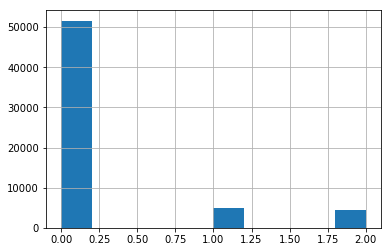

In [5]:
df["relavance"].hist()

In [8]:
X = []

for item in X_temp:
    doc = preprocess_tweet(item)
    X.append(" ".join(doc["processed_text"]))

### Splitting data into test and train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Training pipeline

In [10]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [12]:
#Saving model

In [14]:
joblib.dump(text_clf, 
            r"C:\Users\Uly\Desktop\Desktop\DAX\models\twitter_naive_bayes\model.plk") 

['C:\\Users\\Uly\\Desktop\\Desktop\\DAX\\models\\twitter_naive_bayes\\model.plk']

### Testing accuracy

In [11]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)  

0.97847627797099546